Jupyter Notebook: Feedforward Neural Network (FFNN) with PyTorch
---------------------------------------------------------------
This notebook demonstrates the process of creating, training, and evaluating a Feedforward Neural Network (FFNN) using PyTorch. 
We start with dataset creation, perform preprocessing, and then build and optimize the neural network.
For this we will explore the basic functionality of Pandas, Sklearn, PyTorch.

For pytorch we will focus on key operations such as data loading, data transformations, and how to modify set the device to use GPUs acceleration if avaiable. 
You will be introduced to fundamental components like Tensors, DataLoaders, and Neural Networks that are essential for building and training deep learning models.
The demo is divided in several section, each designed to provide hands-on experience with different PyTorch features. 
We will start by creating a very simple neural network on a very simple problem, with all that is involved (i.e., model creation, dataset and data loader creation, training loop). 
As you progress through the exercises, you will deepen your understanding of PyTorch's capabilities.

We will focuns on aspects about
1. **Dataset Creation:**
   - Generate a synthetic dataset using `make_circles` (10,000 samples, 2D features, 3-class textual labels).
   - Introduce missing values, duplicates, and outliers to simulate real-world data issues.
2. **Data Preprocessing: using Pandas and Sklearn**
   - Remove duplicates.
   - Handle missing values (drop them for simplicity).
   - Convert textual labels into numerical values using label encoding.
   - Normalize features using `StandardScaler`.
3. **Dataset Splitting: using Sklearn**
   - Split the dataset into 70% training, 15% validation, and 15% test sets.
4. **Neural Network Implementation: using Pytorch**
   - Define a FFNN model with input, hidden, and output layers.
   - Train the model using PyTorch.
   - Plot training and validation loss.
   - Compute accuracy for validation and test sets.

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score

import time

## Dataset Creation
In this notebook, we will create a synthetic dataset using the `make_circles` function from sklearn. Specifically we create a simple synthetic dataset with 10,000 samples, 2 features, and a textual multiclass label (3 classes). The dataset will contain missing values, duplicates, and outliers.

In [ ]:
fin=open("dataset_lab_1.csv","r")
intestation=fin.readline().split(",")
X = []
y = []

from torch._C import double
from torch.utils.data import DataLoader, TensorDataset
# load data
train_dataset= TensorDataset()
while temp:=fin.readline():
    X.append([float(i) for i in temp.split(",")[:-1]])
    y.append(double(temp.split(",")[-1].strip()))

# Generate features and labels using make_circles
X, y = make_circles(n_samples=10000, noise=0.2, factor=0.5)

# Introduce outliers
outliers = np.random.choice(10000, 50)
X[outliers] = X[outliers] * 10

# Introduce missing values
missing_indices = np.random.choice(10000, 500)
X[missing_indices] = np.nan

# Create a DataFrame
data = pd.DataFrame(X, columns=['Feature_1', 'Feature_2'])
data['Label'] = y

# Introduce duplicates
#data = data.append(data.iloc[:100])
data = pd.concat([data, data.iloc[:100]], ignore_index=True)


data = data.sample(frac=1).reset_index(drop=True)

data.head()

,Feature_1,Feature_2,Label
0,-0.785661,-0.457345,Class_A
1,-0.300848,-0.672933,Class_A
2,-1.203520,0.017430,Class_A
3,-0.137972,0.017378,Class_B
4,0.290255,0.722172,Class_C


## Preprocessing

The preprocessing stage is a foundamental step to make the dataset ready for the Deep Learning task 

 **Data Preprocessing: using Pandas and Sklearn**
   - Remove duplicates with `drop_duplicates`.
   - Handle missing values (drop them for simplicity) with `dropna`.
   - Convert textual labels into numerical values using `LabelEncoder` function.
   - Finally normalize features using `StandardScaler` as it contains outlier.

In [3]:
# Remove duplicates
print("Number of rows before duplicates", data.size)
data = data.drop_duplicates()
print("Number of rows after duplicates", data.size)

# Remove rows with missing values
data = data.dropna()
print("Number of rows after missing values", data.size)

# Encode labels
label_encoder = LabelEncoder()
data['Label'] = label_encoder.fit_transform(data['Label'])

data.head()

Number of rows before duplicates 30300
Number of rows after duplicates 28539
Number of rows after missing values 28530


,Feature_1,Feature_2,Label
0,-0.785661,-0.457345,0
1,-0.300848,-0.672933,0
2,-1.203520,0.017430,0
3,-0.137972,0.017378,1
4,0.290255,0.722172,2


## Data Visualization

Given the dataset semplicity in 2-Dimenions we can visualize the full dataset.
Since there are outliers we will use 2 different visualization

    1) Using the full range
    2) Using customize the data range to better visualize the real data distribution
  
 **Please note:** that we usually cannot visualize all features of the dataset together, as there are usually many more than 2 features  

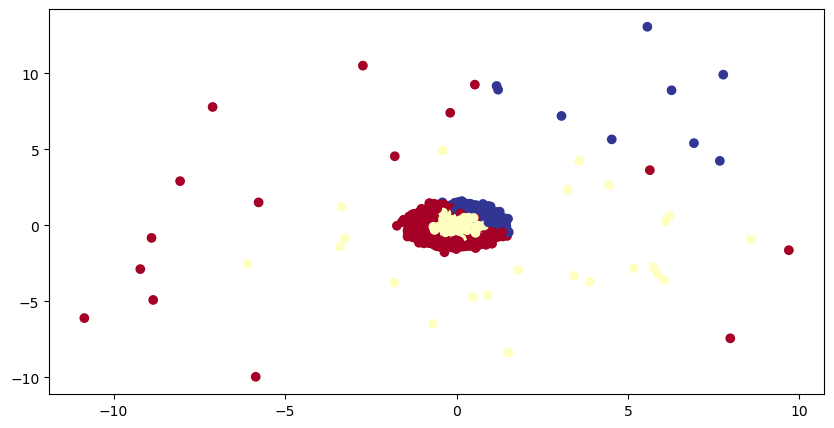

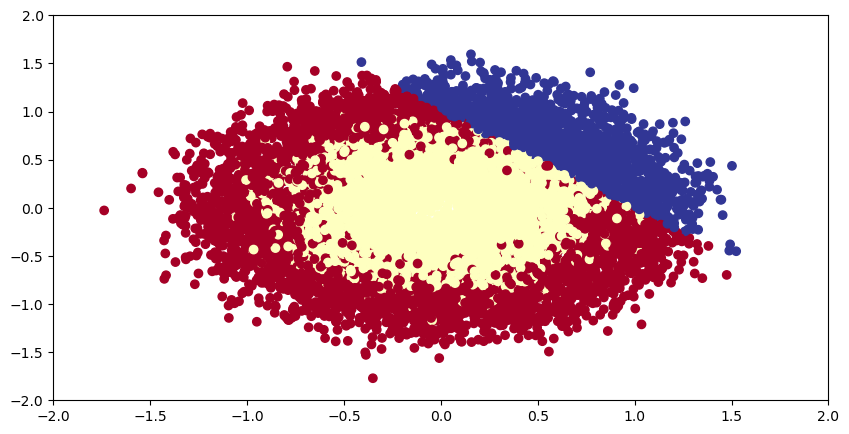

In [4]:
fig, ax = plt.subplots(figsize=(10,5))
plt.scatter(x=data["Feature_1"].values, 
            y=data["Feature_2"].values, 
            c=data["Label"].values, 
            cmap=plt.cm.RdYlBu)
plt.show()
plt.close()

fig, ax = plt.subplots(figsize=(10,5))
plt.scatter(x=data["Feature_1"].values, 
            y=data["Feature_2"].values, 
            c=data["Label"].values, 
            cmap=plt.cm.RdYlBu)
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.show()
plt.close()

## Dataset Splitting Explanation

This section of the code is responsible for **splitting the dataset** into training, validation, and test sets. Proper dataset splitting ensures that the model is trained effectively, validated for hyperparameter tuning, and tested on unseen data for generalization.

  - **X**: Feature matrix containing Feature_1 and Feature_2, converted into a NumPy array.
  - **y**: y: Target variable (labels), also converted into a NumPy array for classification.
  - **Training Set (X_train, y_train)** → 60% of the dataset, used for model training.
  - **Temporary Set (X_temp, y_temp)** → 40% of the dataset, which will be further split into validation and test sets.
  
The **Temporary Set** is then split in 2 parts to have a **validation** and a **test** set
  - **Validation Set (X_val, y_val)** → 20% of the original dataset (half of X_temp).
  - **Test Set (X_test, y_test)** → 20% of the original dataset.

Final Dataset Split Summary
   - **Training Set** → 60%
   - **Validation Set** → 20%
   - **Test Set** → 20%

In [5]:
# Split the dataset
X = data[['Feature_1', 'Feature_2']].values
y = data['Label'].values

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

## Standardize the Dataset
## **Feature Standardization Explanation**

Feature standardization is an essential preprocessing step in machine learning, especially for models that rely on gradient-based optimization, such as neural networks. Standardizing the features ensures that all input variables have a **mean of 0** and a **standard deviation of 1**, which improves model convergence and prevents certain features from dominating due to scale differences.

  - `StandardScaler`is a class from sklearn.preprocessing that standardizes numerical data. It computes the mean and standard deviation of each feature. So it works well also in presence of outliers
  - The `.fit()` method calculates the mean and standard deviation from the training data.
  - The `.transform()` method applies the transformation
  
**Notice:** 
  - The `fit` is done **only** considering the values in the training dataset. `transform` modifies the vadidation/test set. 
  - If  **values** present in the **validation/test** set **ARE NOT** present in the **training set**, the `transform` function may fail or needs to handle this missing encoding values.  

In [6]:
# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

#### Tensors
**Tensors** in PyTorch Tensors are the primary data structure in PyTorch. They are similar to NumPy arrays but have added functionality that supports GPU acceleration and automatic differentiation (*autograd*).

In [7]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

Note that torch tensors use, by default, float32 (single precision) data type. NumPy, instead, defaults to float64 (double precision).

This happens for performance-related reasons: float32 operations are faster than float64.

**Be carefuls on conversion**

## **V1: A simple neural network**

### **1.1 Building and Understanding the Simple Linear Model**

In this exercise, we implement a simple linear model using PyTorch to understand the foundational concepts of model parameters, including **weights** and **biases**. A univariate linear model is one of the most basic forms of machine learning models and is defined by the equation $y = wx + b$

where:
- $x$ is the input feature,
- $w$ is the weight,
- $b$ is the bias,
- $y$ is the output or prediction.

#### **Model Definition: SimpleLinearModel**

The `SimpleLinearModel` class is a subclass of `nn.Module`, which is the base class for all neural network modules in PyTorch. This class defines a single linear layer using `nn.Linear`, which performs the linear transformation:

`output = input * w + b`

The `SimpleLinearModel` class is structured as follows:

- **`__init__(self, input_size, output_size)`**:
  - This is the constructor method where the linear layer is defined. The `input_size` and `output_size` parameters specify the dimensions of the input and output features, respectively. In this exercise, both the input and output sizes are set to 1, indicating a single feature input and a single prediction output.

- **`forward(self, x)`**:
  - This method defines the forward pass of the model, where the input `x` is passed through the linear layer. The forward pass computes the output by applying the linear transformation described above.

This simple model is trained on a synthetic dataset to learn the relationship between the input features and the target labels. During training, the model iteratively adjusts its weights `w` and bias `b` to minimize the error between the predicted and actual outputs. After training, we can inspect these learned parameters to understand how the model has adapted to the data.

In [8]:
# Define a simple linear model
class SimpleLinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleLinearModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
    
    def forward(self, x):
        return self.linear(x)

In [9]:
# Initialize the model, loss function, and optimizer
model = SimpleLinearModel(2, 3)

#### Using `torch.device` for GPU Acceleration

PyTorch provides seamless support for running operations on both CPUs and GPUs using the `torch.device` object. By leveraging the computational power of GPUs, we can significantly speed up the training process of deep learning models, especially when working with large datasets and complex networks.

In this example, we first check if a GPU is available on the machine. In particular, we check if CUDA is available: CUDA is a software layer that provides an interface to the underlying hardware (GPU). If CUDA (and, as a consequence, a GPU) is detected, the tensors are moved to the GPU memory to accelerate computations. Otherwise, the computations fall back to the CPU (i.e., the tensor are kept on the main memory). This flexibility allows the same code to run efficiently on both CPU-only systems and systems equipped with GPUs.

The `torch.device` method is a convenient way to handle this device-agnostic approach, ensuring that tensors and models are placed on the correct device before training or inference.


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"
print(f"The device is set to: {device}")

The device is set to: cpu


So now we can move the model to the currently selected device (either cuda, or cpu).

In [11]:
model = model.to(device)

---
Note that the model has a `linear` attribute (which we created). This layer has its own attributes: `weight` and `bias`. These are the parameters that the model will learn during training.

The initial values are randomly generated, and the model will adjust them during training to minimize the loss function.

Finally, note that these tensors have the `requires_grad` attribute set to `True`. This attribute is used by PyTorch to determine which tensors should have their gradients computed during the backward pass (i.e., which tensors are learnable parameters). This is used by PyTorch to keep track of the computational graph. 

In [12]:
print("Weight", model.linear.weight)
print("Bias", model.linear.bias)

Weight Parameter containing:
tensor([[ 0.4333,  0.1138],
        [-0.0436,  0.1184],
        [-0.4625, -0.1519]], requires_grad=True)
Bias Parameter containing:
tensor([ 0.3683, -0.1602,  0.4931], requires_grad=True)


#### Criterion and Optimizer

In deep learning, two crucial components used during the training process of a model are the **criterion** and the **optimizer**. Understanding these components is essential for effectively training and fine-tuning neural networks.

##### Criterion (Loss Function)

The **criterion**, also known as the **loss function**, is a measure of how well the model's predictions match the actual target values. During training, the loss function evaluates the difference between the predicted outputs and the true labels, quantifying the error of the model. The goal of training is to minimize this error, thereby improving the model's accuracy. 

Common loss functions include:

- **Cross Entropy**: Used for multi-class classification problems, like our tasks. We typically use PyTorch's `CrossEntropyLoss`, which takes as input the predicted *logits* (not the probabilities, so unnormalized probabilities that have not been passed through a softmax) is applied) and the ground truths. Alternatively, we could combine `LogSoftmax` and `NLLLoss` (Negative Log Likelihood Loss) together, or applying the softmax ourselves and then using a Negative Log Likelihood function. However, for numerical reasons, we generally prefer using the `CrossEntropyLoss` class directly. 
- **Mean Squared Error (MSE)**: Typically used for regression tasks, where the model predicts continuous values.

Here, we use a Cross Entropy loss, since the task involves predicting a label.

##### Optimizer

The **optimizer** is an algorithm or method used to adjust the model's weights to minimize the loss function. It updates the model parameters (weights and biases) based on the gradients computed during backpropagation. The optimizer aims to find the optimal set of parameters that reduce the loss, improving the model’s performance on the training data.

Some common optimizers include:

- **Stochastic Gradient Descent (SGD)**: A basic optimizer that updates the model parameters using a small, randomly selected subset of data (mini-batch) instead of the entire dataset. It’s useful for handling large datasets and reducing computational cost.
- **Adam**: A more advanced optimizer that combines the benefits of two other extensions of SGD, Adaptive Gradient Algorithm (AdaGrad) and Root Mean Square Propagation (RMSProp). It adjusts the learning rate for each parameter dynamically, making it well-suited for complex tasks with sparse gradients.

In this exercise, we use **Adam** as our optimizer.

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Training Loop

The **training loop** is the core component of the training process in deep learning. It involves repeatedly passing the training data through the model, computing the loss, and updating the model's parameters to minimize the loss. Understanding the training loop is essential for effectively training neural networks and fine-tuning models to achieve high performance.

The training loop typically consists of several key steps that are executed for a number of **epochs** (iterations over the entire dataset). Let's break down the principal functions of the training loop:

1. **Forward Pass**

   During the forward pass, the input data is fed through the neural network to produce predictions. These predictions are compared to the actual labels using the **criterion** (loss function) to compute the loss. This step involves:
   
   - Passing the input data to the model.
   - Computing the model's output (predictions).
   - Calculating the loss by comparing the model’s predictions to the true labels.

2. **Loss Computation**

   The computed loss indicates how well or poorly the model is performing on the training data. The goal is to minimize this loss, so it acts as a guide for the optimizer to adjust the model's weights. The loss function provides a differentiable quantity that the optimizer can use to update the model parameters.

3. **Backward Pass (Backpropagation)**

   The backward pass, also known as **backpropagation**, is where the gradients of the loss with respect to each model parameter are calculated. These gradients indicate how much each parameter contributes to the loss, and they are used to update the model's parameters in the direction that reduces the loss:
   
   - Compute the gradients by performing backpropagation.
   - These gradients are stored for use by the optimizer.

4. **Parameter Update**

   After computing the gradients, the **optimizer** uses them to update the model's parameters (weights and biases). This step adjusts the parameters to minimize the loss function. The optimizer’s update rule determines how the parameters are changed based on the gradients, the learning rate, and potentially other factors (like momentum or weight decays). This involves:
   
   - Using the optimizer to adjust the model's parameters based on the computed gradients.
   - Updating the weights to reduce the loss on the next forward pass.

5. **Zero the Gradients**

   After updating the parameters, the gradients need to be zeroed before the next iteration. This step ensures that gradients from the previous epoch do not accumulate with those from the current epoch, which could lead to incorrect updates:
   
   - Set the gradients to zero using `optimizer.zero_grad()` to prevent accumulation from previous epoch.

6. **Repeat for All Epochs**

   The above steps are repeated for for each epoch until the model converges to an optimal solution or reaches the desired number of epochs. Over multiple epochs, the model learns to generalize better to the training data and, ideally, to new, unseen data.

In summary, the training loop is a repetitive process that allows the model to learn from the data by minimizing the loss through gradient-based optimization. Understanding each function within the loop is crucial for successfully training deep learning models and fine-tuning them for specific tasks.

**Notice:** In this case **NO mini-batching** is performed

In [14]:
def training_loop_no_minibatch(model, X_train_tensor, y_val_tensor, device, optimizer, criterion):
    """
    Train the model for a specified number of epochs and track the training and validation losses.
    
    Args:
        model: The neural network model to be trained.
        train_loader: DataLoader for the training dataset.
        val_loader: DataLoader for the validation dataset.
        train_dataset: The entire training dataset.
        val_dataset: The entire validation dataset.
        device: Device to run the model on (CPU or GPU).
        optimizer: The optimization algorithm to use for updating model parameters.
        criterion: The loss function to use for computing the loss.
    
    Returns:
        None: The function plots the training and validation loss over the epochs.
    """
    
    # Record the start time
    start_time = time.time()
    
    # Define training parameters
    num_epochs = 200

    train_losses = []
    val_losses = []

    # Training loop
    for epoch in range(num_epochs):  # Train for epochs
        model.train()  # Set model to training mode
        optimizer.zero_grad()  # Clear previous gradients
        outputs = model(X_train_tensor)  # Forward pass
        loss = criterion(outputs, y_train_tensor)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update model parameters
        train_losses.append(loss.item())  # Store training loss

        #To compute Validation loss during training
        model.eval()  # Set model to evaluation mode
        with torch.no_grad():  # Disable gradient computation for validation
            val_outputs = model(X_val_tensor)  # Forward pass
            val_loss = criterion(val_outputs, y_val_tensor)  # Compute validation loss
            val_losses.append(val_loss)  # Store validation loss        
        if((epoch+1)%20==0):
            print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')


    # Record the end time
    end_time = time.time()
    # Calculate the elapsed time
    elapsed_time = end_time - start_time


    print(f'The function took {elapsed_time:.4f} seconds to execute.')            
    # Plot the training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()        
       
def testing_model_no_minibatch(model,X_tensor,y_tensor , device):
    """
    Evaluate the model on a given tesor and compute accuracy.
    
    Args:
        model: The trained model.
        X_tensor: tensor with the dataset.
        y_tensor: tensor with the label.
        device: Device to run the model on (CPU or GPU).
    
    Returns:
        float: Accuracy of the model on the test dataset.
    """    
    # Record the start time
    start_time = time.time()

    
    model.eval()
    with torch.no_grad():
        outputs = model(X_tensor)
        _, predicted = torch.max(outputs, 1)
        accuracy = accuracy_score(y_tensor, predicted)*100

    # Record the end time
    end_time = time.time()
    # Calculate the elapsed time
    elapsed_time = end_time - start_time


    print(f'The function took {elapsed_time:.4f} seconds to execute.')    
    return accuracy


Epoch 20/200, Train Loss: 1.4290, Val Loss: 1.4242
Epoch 40/200, Train Loss: 1.4018, Val Loss: 1.3977
Epoch 60/200, Train Loss: 1.3758, Val Loss: 1.3719
Epoch 80/200, Train Loss: 1.3507, Val Loss: 1.3470
Epoch 100/200, Train Loss: 1.3267, Val Loss: 1.3230
Epoch 120/200, Train Loss: 1.3036, Val Loss: 1.3000
Epoch 140/200, Train Loss: 1.2816, Val Loss: 1.2779
Epoch 160/200, Train Loss: 1.2605, Val Loss: 1.2567
Epoch 180/200, Train Loss: 1.2403, Val Loss: 1.2364
Epoch 200/200, Train Loss: 1.2210, Val Loss: 1.2170
The function took 0.2464 seconds to execute.


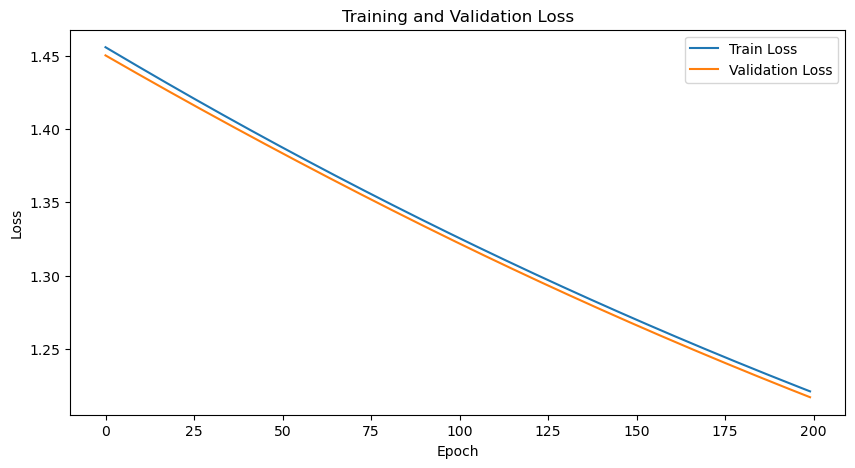

In [15]:
training_loop_no_minibatch(model, X_train_tensor, y_val_tensor, device, optimizer, criterion)

In [16]:
# Inspecting the learned weights and biases
weights = model.linear.weight.data
biases = model.linear.bias.data

print(f'Learned weights: {weights}')
print(f'Learned biases: {biases}')

Learned weights: tensor([[ 0.2422, -0.0721],
        [ 0.0084, -0.0432],
        [-0.2709,  0.0300]])
Learned biases: tensor([0.3961, 0.0310, 0.3033])


In [17]:
train_accuracy = testing_model_no_minibatch(model,X_train_tensor,y_train_tensor,device)
val_accuracy = testing_model_no_minibatch(model,X_val_tensor,y_val_tensor,device)
test_accuracy = testing_model_no_minibatch(model,X_test_tensor,y_test_tensor,device)

print(f'Train Accuracy: {train_accuracy:.4f}')
print(f'Validation Accuracy: {val_accuracy:.4f}')    
print(f'Test Accuracy: {test_accuracy:.4f}') 

The function took 0.0027 seconds to execute.
The function took 0.0011 seconds to execute.
The function took 0.0010 seconds to execute.
Train Accuracy: 17.5429
Validation Accuracy: 17.2450
Test Accuracy: 16.5089


**TAKEAWAY**: These curve did not reach the convercence longer training may benefit the performance.

## **V2: Introduce non-linearity in the neural network**

  - Include a non linear activation function to introduce non-linearity in the architecture
  - Increment the number of training epochs to serch for converngence

In [18]:
# Define the neural network
class NonLinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(NonLinearModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, output_size)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x


In [19]:
# Initialize the model, loss function, and optimizer
model = NonLinearModel(2, 3)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch 20/200, Train Loss: 0.8901, Val Loss: 0.8829
Epoch 40/200, Train Loss: 0.6565, Val Loss: 0.6438
Epoch 60/200, Train Loss: 0.4412, Val Loss: 0.4237
Epoch 80/200, Train Loss: 0.3368, Val Loss: 0.3326
Epoch 100/200, Train Loss: 0.2967, Val Loss: 0.2987
Epoch 120/200, Train Loss: 0.2766, Val Loss: 0.2770
Epoch 140/200, Train Loss: 0.2671, Val Loss: 0.2697
Epoch 160/200, Train Loss: 0.2610, Val Loss: 0.2646
Epoch 180/200, Train Loss: 0.2567, Val Loss: 0.2609
Epoch 200/200, Train Loss: 0.2535, Val Loss: 0.2583
The function took 0.8519 seconds to execute.


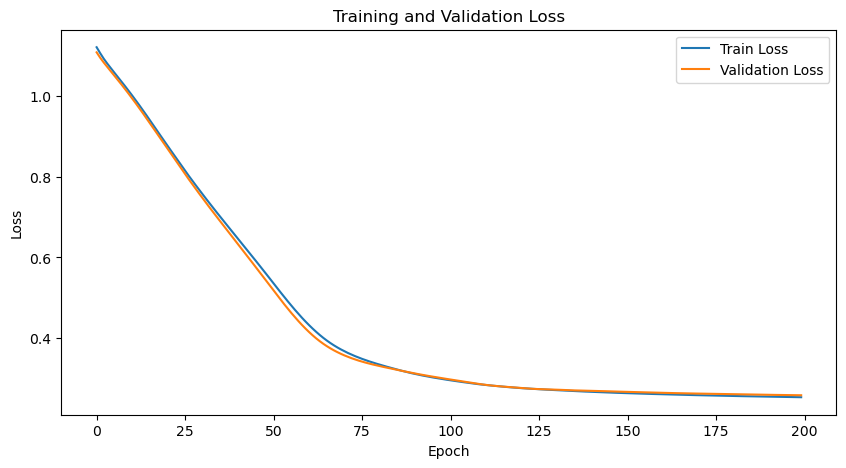

In [20]:
training_loop_no_minibatch(model, X_train_tensor, y_val_tensor, device, optimizer, criterion)

In [21]:
# Inspecting the learned weights and biases
print(f'Learned weights: {model.fc1.weight.data}')
print(f'Learned biases: {model.fc1.bias.data}')
print(f'Learned weights: {model.fc2.weight.data}')
print(f'Learned biases: {model.fc2.bias.data}')
print(f'Learned weights: {model.fc3.weight.data}')
print(f'Learned biases: {model.fc3.bias.data}')
print(f'Learned weights: {model.fc4.weight.data}')
print(f'Learned biases: {model.fc4.bias.data}')

Learned weights: tensor([[ 0.0414,  0.5454],
        [ 0.5185, -0.0017],
        [-0.4759,  0.7204],
        [ 0.1587, -0.4318],
        [ 0.7401,  0.3312],
        [-0.4201, -0.0085],
        [-0.1084,  0.5654],
        [-0.4840,  0.6272],
        [ 0.4313, -0.3644],
        [ 0.4546,  0.4979],
        [-0.2569, -0.0386],
        [ 0.4667,  0.2158],
        [ 0.6207,  0.4636],
        [-0.6550, -0.3416],
        [-0.0631, -0.5507],
        [ 0.3238, -0.2149],
        [-0.5874,  0.4187],
        [-0.2806, -0.2794],
        [ 0.3625, -0.0531],
        [ 0.3759,  0.6073],
        [ 0.7432, -0.3089],
        [-0.4752, -0.3221],
        [ 0.0366,  0.5484],
        [-0.2886,  0.5126],
        [-0.6782, -0.4076],
        [-0.6641,  0.5837],
        [-0.7299, -0.0138],
        [-0.4687,  0.5124],
        [ 0.5799, -0.7661],
        [-0.6638,  0.8049],
        [-0.5840, -0.5706],
        [ 0.1023, -0.5016],
        [ 0.1816,  0.3063],
        [ 0.5134, -0.4467],
        [-0.8109, -0.6519],
   

In [22]:
train_accuracy = testing_model_no_minibatch(model,X_train_tensor,y_train_tensor,device)
val_accuracy = testing_model_no_minibatch(model,X_val_tensor,y_val_tensor,device)
test_accuracy = testing_model_no_minibatch(model,X_test_tensor,y_test_tensor,device)

print(f'Train Accuracy: {train_accuracy:.4f}')
print(f'Validation Accuracy: {val_accuracy:.4f}')    
print(f'Test Accuracy: {test_accuracy:.4f}') 

The function took 0.0022 seconds to execute.
The function took 0.0017 seconds to execute.
The function took 0.0017 seconds to execute.
Train Accuracy: 89.7827
Validation Accuracy: 89.6951
Test Accuracy: 89.9054


## **V3: Add mini-batches in the neural network**
  - mini-batches can improve the model performance and reduce the traning time
  - **NOTICE**: This is a toy example!

In [23]:
from torch.utils.data import DataLoader, TensorDataset

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [24]:
def training_loop(model, train_loader, val_loader, train_dataset, val_dataset, device, optimizer, criterion,min_delta = None, patience = None):
    """
    Train the model for a specified number of epochs and track the training and validation losses.
    
    Args:
        model: The neural network model to be trained.
        train_loader: DataLoader for the training dataset.
        val_loader: DataLoader for the validation dataset.
        train_dataset: The entire training dataset.
        val_dataset: The entire validation dataset.
        device: Device to run the model on (CPU or GPU).
        optimizer: The optimization algorithm to use for updating model parameters.
        criterion: The loss function to use for computing the loss.
    
    Returns:
        None: The function plots the training and validation loss over the epochs.
    """
    

    # Record the start time
    start_time = time.time()
    
    # Define training parameters
    num_epochs = 200

    train_losses = []
    val_losses = []

    best_val_loss = float('inf')
    trigger_times = 0     # how many epochs since last improvement
    best_model_state = None    
    # Training loop
    for epoch in range(num_epochs):  # Train for epochs
        train_loss = 0
        val_loss = 0
        model.train()  # Set model to training mode
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)  # Move batch to GPU
            optimizer.zero_grad()  # Clear previous gradients
            outputs = model(batch_X)  # Forward pass
            loss = criterion(outputs, batch_y)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update model parameters
            train_loss += loss.item() * batch_X.size(0)
        train_loss /= len(train_dataset)
        train_losses.append(train_loss)  # Store training loss

        # Compute Validation loss during training
        model.eval()  # Set model to evaluation mode
        with torch.no_grad():  # Disable gradient computation for validation
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)  # Move batch to GPU
                val_outputs = model(batch_X)  # Forward pass
                loss = criterion(val_outputs, batch_y)  # Compute validation loss
                val_loss += loss.item() * batch_X.size(0)
            val_loss /= len(val_dataset)
            val_losses.append(val_loss)  # Store validation loss        
        if (epoch + 1) % 20 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')

        # ---- Early Stopping ----
        if(min_delta!= None):
            if val_loss < best_val_loss - min_delta:
                best_val_loss = val_loss
                best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
                trigger_times = 0
            else:
                trigger_times += 1
                if trigger_times >= patience:
                    print(f"Early stopping at epoch {epoch+1} (best val loss: {best_val_loss:.6f})")
                    break

    # ---- Restore best model ----
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
            
    # Record the end time
    end_time = time.time()
    # Calculate the elapsed time
    elapsed_time = end_time - start_time
    print(f'The function took {elapsed_time:.4f} seconds to execute.')    
            
    # Plot the training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()
        
    return

def testing_model(model, dataloader, device):
    """
    Evaluate the model on a given dataloader and compute accuracy.
    
    Args:
        model: The trained model.
        dataloader: DataLoader for the dataset.
        device: Device to run the model on (CPU or GPU).
    
    Returns:
        float: Accuracy of the model on the test dataset.
    """
    # Record the start time
    start_time = time.time()
   
    model.eval()  # Set the model to evaluation mode
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():  # Disable gradient computation for efficiency
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)  # Get the class with highest score
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_predictions) * 100
    
    # Record the end time
    end_time = time.time()
    # Calculate the elapsed time
    elapsed_time = end_time - start_time
    print(f'The function took {elapsed_time:.4f} seconds to execute.')    
    
    return accuracy

In [25]:
# Initialize the model, loss function, and optimizer
model = NonLinearModel(2, 3)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch 20/200, Train Loss: 0.2519, Val Loss: 0.2578
Epoch 40/200, Train Loss: 0.2505, Val Loss: 0.2537
Epoch 60/200, Train Loss: 0.2484, Val Loss: 0.2623
Epoch 80/200, Train Loss: 0.2409, Val Loss: 0.2517
Epoch 100/200, Train Loss: 0.2444, Val Loss: 0.2480
Epoch 120/200, Train Loss: 0.2387, Val Loss: 0.2501
Epoch 140/200, Train Loss: 0.2353, Val Loss: 0.2485
Epoch 160/200, Train Loss: 0.2389, Val Loss: 0.2823
Epoch 180/200, Train Loss: 0.2352, Val Loss: 0.2597
Epoch 200/200, Train Loss: 0.2368, Val Loss: 0.2589
The function took 124.9977 seconds to execute.


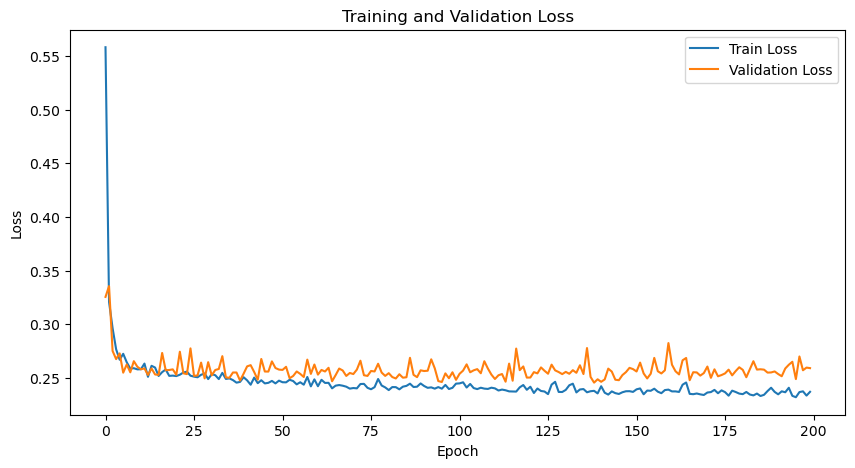

In [26]:
training_loop(model, train_loader, val_loader, train_dataset, val_dataset, device, optimizer, criterion)

In [27]:
train_accuracy = testing_model(model,train_loader,device)
val_accuracy = testing_model(model,val_loader,device)
test_accuracy = testing_model(model,test_loader,device)

print(f'Train Accuracy: {train_accuracy:.4f}')
print(f'Validation Accuracy: {val_accuracy:.4f}')    
print(f'Test Accuracy: {test_accuracy:.4f}') 

The function took 0.2067 seconds to execute.
The function took 0.0677 seconds to execute.
The function took 0.0684 seconds to execute.
Train Accuracy: 90.3610
Validation Accuracy: 89.8002
Test Accuracy: 89.7476


## **V4: Early stopping in the neural network**
  - Introducing Eerly Stopping
  - **NOTICE**: This is a toy example! So this may be useless!

In [28]:
# Initialize the model, loss function, and optimizer
model = NonLinearModel(2, 3)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Initialize the early stopping parameters
min_delta = 0.00001
patience = 20

Epoch 20/200, Train Loss: 0.2537, Val Loss: 0.2530
Early stopping at epoch 37 (best val loss: 0.251346)
The function took 23.0251 seconds to execute.


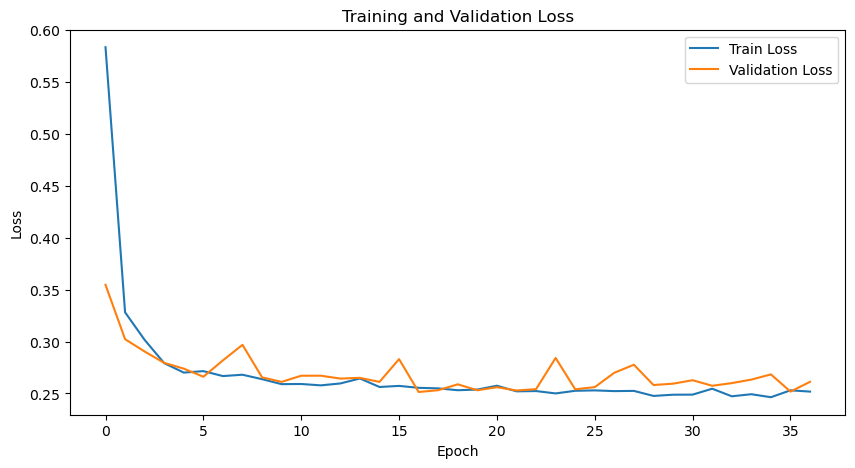

In [29]:
training_loop(model, train_loader, val_loader, train_dataset, val_dataset, device, optimizer, criterion,min_delta,patience)

In [30]:
train_accuracy = testing_model(model,train_loader,device)
val_accuracy = testing_model(model,val_loader,device)
test_accuracy = testing_model(model,test_loader,device)

print(f'Train Accuracy: {train_accuracy:.4f}')
print(f'Validation Accuracy: {val_accuracy:.4f}')    
print(f'Test Accuracy: {test_accuracy:.4f}') 

The function took 0.2039 seconds to execute.
The function took 0.0675 seconds to execute.
The function took 0.0682 seconds to execute.
Train Accuracy: 89.6250
Validation Accuracy: 89.6951
Test Accuracy: 89.8528


## **V6: Normalization in the neural network**
  - Add some normalization tecnquies for improving the performance
  - **NOTICE**: This is a toy example! So this may be useless!

In [31]:
# Define the neural network with dropout
class NonLinearModelDropOut(nn.Module):
    def __init__(self, input_size, output_size):
        super(NonLinearModelDropOut, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [32]:
# Define the neural network with batch normalization
class NonLinearModelNormalization(nn.Module):
    def __init__(self, input_size, output_size):
        super(NonLinearModelNormalization, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        hidden_size = 128 #output of the previous layer        
        self.bn1 = nn.BatchNorm1d(hidden_size)  # Batch Normalization Layer
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        hidden_size = 32 #output of the previous layer
        self.bn3 = nn.BatchNorm1d(hidden_size)  # Batch Normalization Layer 
        self.fc4 = nn.Linear(32, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.bn1(x)
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.bn3(x)
        x = self.fc4(x)
        return x

In [33]:
# Initialize the model, loss function, and optimizer
model = NonLinearModelDropOut(2, 3)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch 20/200, Train Loss: 0.3165, Val Loss: 0.2606
Epoch 40/200, Train Loss: 0.2818, Val Loss: 0.2541
Epoch 60/200, Train Loss: 0.2817, Val Loss: 0.2502
Epoch 80/200, Train Loss: 0.2797, Val Loss: 0.2493
Epoch 100/200, Train Loss: 0.2771, Val Loss: 0.2562
Epoch 120/200, Train Loss: 0.2686, Val Loss: 0.2526
Epoch 140/200, Train Loss: 0.2728, Val Loss: 0.2535
Epoch 160/200, Train Loss: 0.2687, Val Loss: 0.2616
Epoch 180/200, Train Loss: 0.2653, Val Loss: 0.2517
Epoch 200/200, Train Loss: 0.2684, Val Loss: 0.2541
The function took 140.1090 seconds to execute.


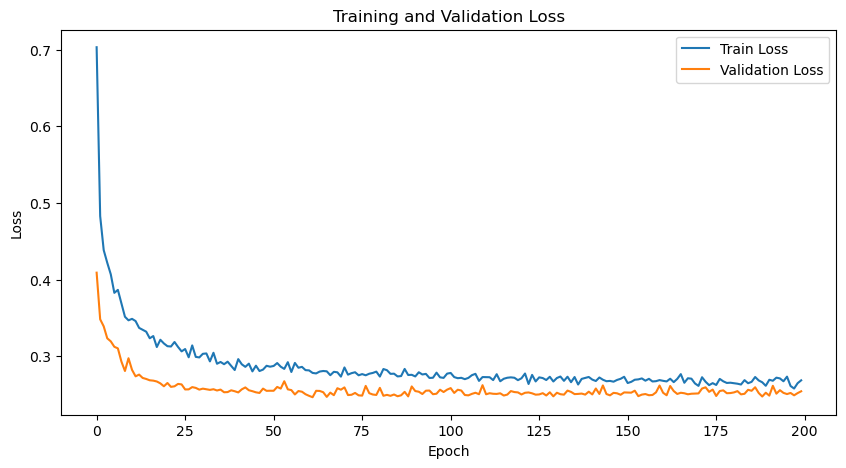

In [34]:
training_loop(model, train_loader, val_loader, train_dataset, val_dataset, device, optimizer, criterion)

In [35]:
train_accuracy = testing_model(model,train_loader,device)
val_accuracy = testing_model(model,val_loader,device)
test_accuracy = testing_model(model,test_loader,device)

print(f'Train Accuracy: {train_accuracy:.4f}')
print(f'Validation Accuracy: {val_accuracy:.4f}')    
print(f'Test Accuracy: {test_accuracy:.4f}') 

The function took 0.2116 seconds to execute.
The function took 0.0695 seconds to execute.
The function took 0.0699 seconds to execute.
Train Accuracy: 89.7827
Validation Accuracy: 89.0641
Test Accuracy: 89.3270


### With batch normalization and weigth decay

In [36]:
# Initialize the model, loss function, and optimizer
model = NonLinearModelNormalization(2, 3)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.02)

Epoch 20/200, Train Loss: 0.3802, Val Loss: 0.4322
Epoch 40/200, Train Loss: 0.3911, Val Loss: 0.3879
Epoch 60/200, Train Loss: 0.3830, Val Loss: 0.4795
Epoch 80/200, Train Loss: 0.3825, Val Loss: 0.4768
Epoch 100/200, Train Loss: 0.3816, Val Loss: 0.4492
Epoch 120/200, Train Loss: 0.3853, Val Loss: 0.4677
Epoch 140/200, Train Loss: 0.3898, Val Loss: 0.5102
Epoch 160/200, Train Loss: 0.3880, Val Loss: 0.3655
Epoch 180/200, Train Loss: 0.3881, Val Loss: 0.5346
Epoch 200/200, Train Loss: 0.3898, Val Loss: 0.4285
The function took 196.3088 seconds to execute.


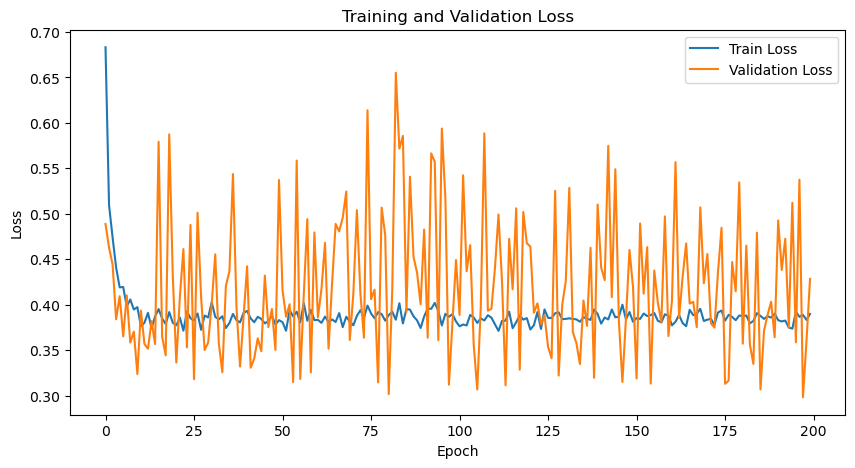

In [37]:
training_loop(model, train_loader, val_loader, train_dataset, val_dataset, device, optimizer, criterion)

In [38]:
train_accuracy = testing_model(model,train_loader,device)
val_accuracy = testing_model(model,val_loader,device)
test_accuracy = testing_model(model,test_loader,device)

print(f'Train Accuracy: {train_accuracy:.4f}')
print(f'Validation Accuracy: {val_accuracy:.4f}')    
print(f'Test Accuracy: {test_accuracy:.4f}') 

The function took 0.3212 seconds to execute.
The function took 0.1065 seconds to execute.
The function took 0.1075 seconds to execute.
Train Accuracy: 86.8209
Validation Accuracy: 87.0662
Test Accuracy: 86.2250


## **V7: Using GPUs**
  - Change Device

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"The device is set to: {device}")

The device is set to: cpu


In [40]:
# Convert data to PyTorch tensors and send to CUDA
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

In [41]:
# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [42]:
# Initialize the model, loss function, and optimizer
model = NonLinearModelNormalization(2, 3)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.02)

Epoch 20/200, Train Loss: 0.3860, Val Loss: 0.4440
Epoch 40/200, Train Loss: 0.3817, Val Loss: 0.4996
Epoch 60/200, Train Loss: 0.3913, Val Loss: 0.5752
Epoch 80/200, Train Loss: 0.3896, Val Loss: 0.6098
Epoch 100/200, Train Loss: 0.3841, Val Loss: 0.6979
Epoch 120/200, Train Loss: 0.3844, Val Loss: 0.4368
Epoch 140/200, Train Loss: 0.3838, Val Loss: 0.4875
Epoch 160/200, Train Loss: 0.3846, Val Loss: 0.3763
Epoch 180/200, Train Loss: 0.3875, Val Loss: 0.5037
Epoch 200/200, Train Loss: 0.3849, Val Loss: 0.4496
The function took 197.2629 seconds to execute.


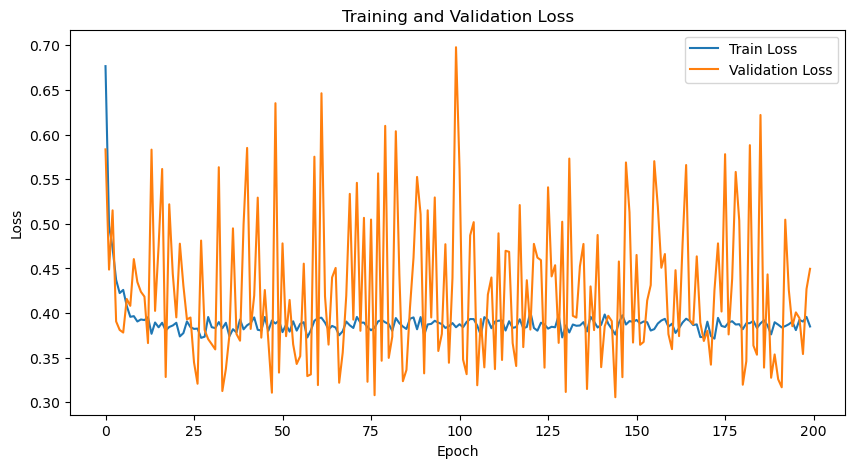

In [43]:
training_loop(model, train_loader, val_loader, train_dataset, val_dataset, device, optimizer, criterion)

In [44]:
train_accuracy = testing_model(model,train_loader,device)
val_accuracy = testing_model(model,val_loader,device)
test_accuracy = testing_model(model,test_loader,device)

print(f'Train Accuracy: {train_accuracy:.4f}')
print(f'Validation Accuracy: {val_accuracy:.4f}')    
print(f'Test Accuracy: {test_accuracy:.4f}') 

The function took 0.3208 seconds to execute.
The function took 0.1075 seconds to execute.
The function took 0.1068 seconds to execute.
Train Accuracy: 87.9075
Validation Accuracy: 88.6961
Test Accuracy: 87.8023
